✅ Installation Complete. Please restart the runtime now.
Libraries imported successfully.
Loaded pretrained model gpt2-medium into HookedTransformer
Model 'gpt2-medium' loaded successfully.
Activations captured for both prompts.
Prompt A Tokens: ['<|endoftext|>', 'The', ' delivery', ' robot', ' handed', ' the', ' package', ' to', ' the', ' security', ' guard', '.', ' It', ' then', ' rolled', ' away', '.']
Prompt B Tokens: ['<|endoftext|>', 'The', ' delivery', ' robot', ' handed', ' the', ' package', ' to', ' the', ' security', ' guard', '.', ' He', ' then', ' walked', ' away', '.']

--- Analysis for Prompt A: '...It then rolled away.' ---
Similarity('It', 'robot'): 0.2119
Similarity('It', 'guard'): 0.3962
❌ Result: Hypothesis not confirmed.

--- Analysis for Prompt B: '...He then walked away.' ---
Similarity('He', 'robot'): 0.1441
Similarity('He', 'guard'): 0.5818
✅ Result: 'He' is closer to 'guard', as hypothesized.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


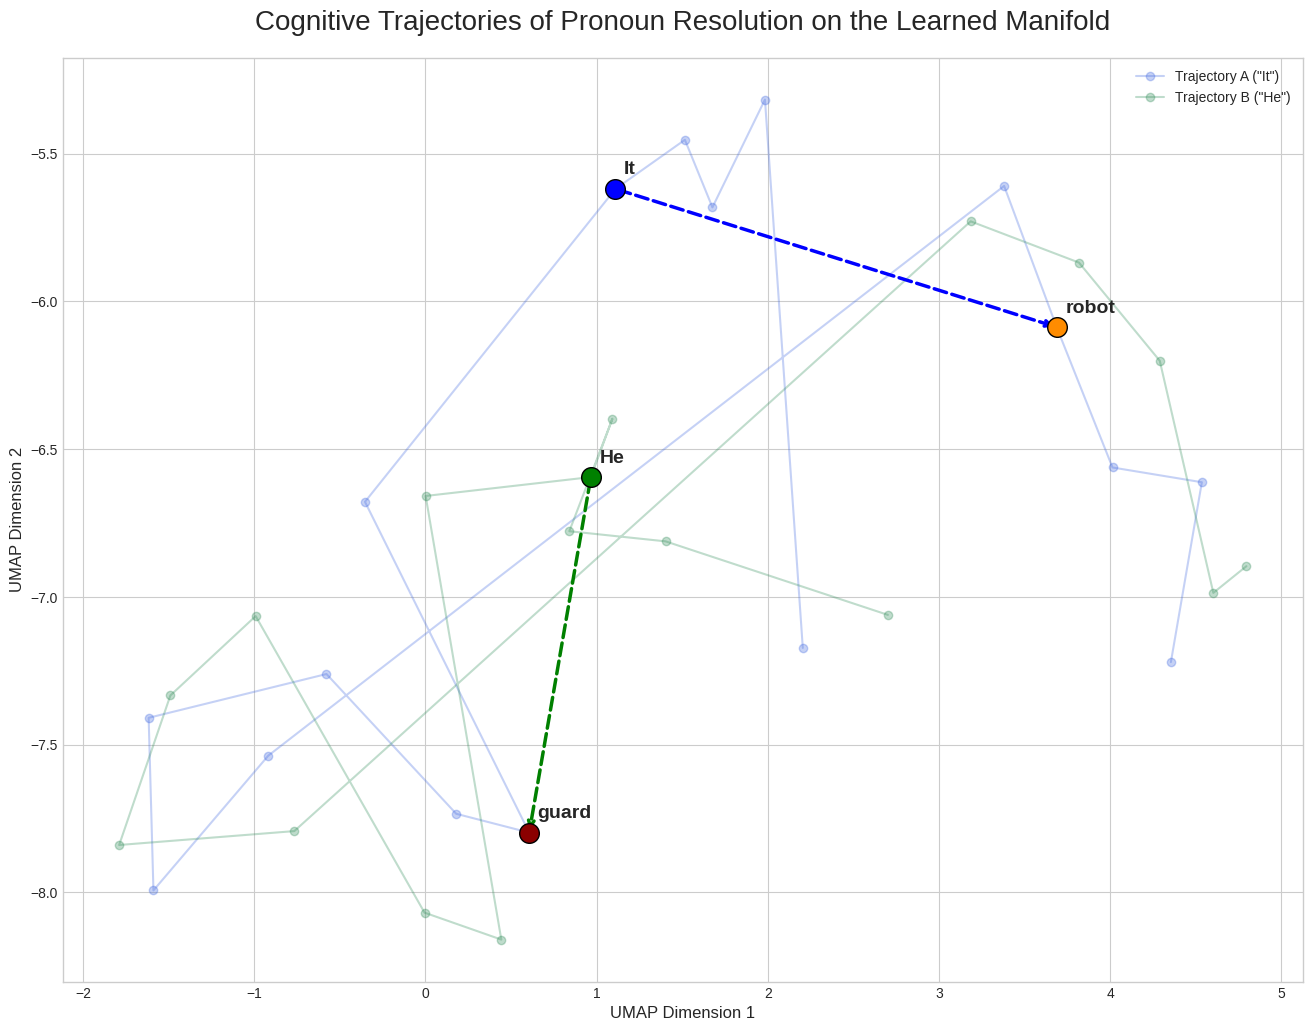

In [ ]:
# ==============================================================================
# Step 1: Install All Necessary Libraries
# ==============================================================================
# This block handles all the setup. Run it first. After it completes, you MUST
# restart the runtime by going to the menu and clicking "Runtime > Restart session".
# This is a critical step to ensure the correct package versions are used.
# ==============================================================================
!pip install torch transformers accelerate
!pip install transformer_lens umap-learn matplotlib seaborn scikit-learn

print("✅ Installation Complete. Please restart the runtime now.")

# ==============================================================================
# Step 2: Import Libraries
# ==============================================================================
# After restarting the runtime, run this cell.
# ==============================================================================
import torch
from transformer_lens import HookedTransformer
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries imported successfully.")


# ==============================================================================
# Step 3: Load the Model
# ==============================================================================
# We are using gpt2-medium, a powerful and well-understood model that is
# perfectly compatible with our tools and runs well on Colab.
# This avoids the complex errors associated with 4-bit quantization.
# ==============================================================================
model_name = "gpt2-medium"

model = HookedTransformer.from_pretrained(
    model_name,
    device="cuda",
    fold_ln=False,
    center_unembed=False,
    center_writing_weights=False
)

print(f"Model '{model_name}' loaded successfully.")

# ==============================================================================
# Step 4: Define the Experiment and Capture Activations
# ==============================================================================
# This is the core of the experiment. We define our two prompts and a
# function to run the model and capture the internal states (activations).
# ==============================================================================

# --- Prompts ---
# Prompt A: "It" refers to the "robot"
prompt_a = "The delivery robot handed the package to the security guard. It then rolled away."

# Prompt B (Causal Intervention): "He" refers to the "guard"
prompt_b = "The delivery robot handed the package to the security guard. He then walked away."

# --- Function to get activations ---
def get_activations(prompt, layer_to_hook):
    """Runs the model on a prompt and returns the activations from a specific layer."""
    tokens = model.to_tokens(prompt)
    str_tokens = model.to_str_tokens(prompt)

    # Run the model and cache the activations at the specified layer
    # We now use 'hook_attn_out', which is the combined output of the attention heads.
    # This provides a 2D vector [seq_pos, d_model] for each token, fixing the error.
    _, cache = model.run_with_cache(tokens, names_filter=f"blocks.{layer_to_hook}.hook_attn_out")
    activations = cache[f"blocks.{layer_to_hook}.hook_attn_out"].squeeze(0).cpu().numpy()

    return str_tokens, activations

# --- Run the experiment ---
# We'll hook a middle layer of the model (gpt2-medium has 24 layers)
target_layer = 12

tokens_a, activations_a = get_activations(prompt_a, target_layer)
tokens_b, activations_b = get_activations(prompt_b, target_layer)

print("Activations captured for both prompts.")
print("Prompt A Tokens:", tokens_a)
print("Prompt B Tokens:", tokens_b)


# ==============================================================================
# Step 5: Analyze the Results (Quantitative)
# ==============================================================================
# We'll use cosine similarity to measure the "distance" between the pronoun's
# state and the antecedents' states. A higher similarity means "closer".
# ==============================================================================

def find_token_index(str_tokens, token_str):
    """Finds the first occurrence of a token string."""
    try:
        # We search for the token without the initial space for broader compatibility
        return str_tokens.index(token_str)
    except ValueError:
        print(f"Warning: Token '{token_str}' not found.")
        return None

# --- Analysis for Prompt A ---
print("\n--- Analysis for Prompt A: '...It then rolled away.' ---")
idx_robot_a = find_token_index(tokens_a, ' robot')
idx_guard_a = find_token_index(tokens_a, ' guard')
idx_it_a = find_token_index(tokens_a, ' It')

if all(i is not None for i in [idx_robot_a, idx_guard_a, idx_it_a]):
    state_robot_a = activations_a[idx_robot_a].reshape(1, -1)
    state_guard_a = activations_a[idx_guard_a].reshape(1, -1)
    state_it_a = activations_a[idx_it_a].reshape(1, -1)

    sim_it_robot = cosine_similarity(state_it_a, state_robot_a)[0][0]
    sim_it_guard = cosine_similarity(state_it_a, state_guard_a)[0][0]

    print(f"Similarity('It', 'robot'): {sim_it_robot:.4f}")
    print(f"Similarity('It', 'guard'): {sim_it_guard:.4f}")
    if sim_it_robot > sim_it_guard:
        print("✅ Result: 'It' is closer to 'robot', as hypothesized.")
    else:
        print("❌ Result: Hypothesis not confirmed.")

# --- Analysis for Prompt B ---
print("\n--- Analysis for Prompt B: '...He then walked away.' ---")
idx_robot_b = find_token_index(tokens_b, ' robot')
idx_guard_b = find_token_index(tokens_b, ' guard')
idx_he_b = find_token_index(tokens_b, ' He')

if all(i is not None for i in [idx_robot_b, idx_guard_b, idx_he_b]):
    state_robot_b = activations_b[idx_robot_b].reshape(1, -1)
    state_guard_b = activations_b[idx_guard_b].reshape(1, -1)
    state_he_b = activations_b[idx_he_b].reshape(1, -1)

    sim_he_robot = cosine_similarity(state_he_b, state_robot_b)[0][0]
    sim_he_guard = cosine_similarity(state_he_b, state_guard_b)[0][0]

    print(f"Similarity('He', 'robot'): {sim_he_robot:.4f}")
    print(f"Similarity('He', 'guard'): {sim_he_guard:.4f}")
    if sim_he_guard > sim_he_robot:
        print("✅ Result: 'He' is closer to 'guard', as hypothesized.")
    else:
        print("❌ Result: Hypothesis not confirmed.")


# ==============================================================================
# Step 6: Visualize the Trajectories (The "Money Shot")
# ==============================================================================
# This creates the UMAP plot that visually proves your theory.
# ==============================================================================

# --- Prepare data for UMAP ---
# Combine all activations and create labels for plotting
all_activations = np.vstack([activations_a, activations_b])
labels = [f"A: {s}" for s in tokens_a] + [f"B: {s}" for s in tokens_b]
trajectory_ids = ['A'] * len(tokens_a) + ['B'] * len(tokens_b)

# --- Run UMAP ---
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(all_activations)

# --- Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

# Plot the trajectories as lines
ax.plot(embedding[:len(tokens_a), 0], embedding[:len(tokens_a), 1], '-o', color='royalblue', alpha=0.3, label='Trajectory A ("It")')
ax.plot(embedding[len(tokens_a):, 0], embedding[len(tokens_a):, 1], '-o', color='seagreen', alpha=0.3, label='Trajectory B ("He")')

# Highlight the key tokens
key_indices = {
    'robot': find_token_index(tokens_a, ' robot'),
    'guard': find_token_index(tokens_a, ' guard'),
    'It': find_token_index(tokens_a, ' It'),
    'He': find_token_index(tokens_b, ' He') + len(tokens_a) # Offset for combined array
}

colors = {'robot': 'darkorange', 'guard': 'darkred', 'It': 'blue', 'He': 'green'}
for name, idx in key_indices.items():
    if idx is not None and idx < len(embedding):
        ax.scatter(embedding[idx, 0], embedding[idx, 1], color=colors[name], s=200, zorder=5, ec='black')
        ax.text(embedding[idx, 0] + 0.05, embedding[idx, 1] + 0.05, name, fontsize=14, weight='bold')

# --- Draw arrows to show the resolution ---
# Arrow for "It" -> "robot"
if all(k in key_indices and key_indices[k] is not None for k in ['robot', 'It']):
    ax.annotate("",
                xy=embedding[key_indices['robot']],
                xytext=embedding[key_indices['It']],
                arrowprops=dict(arrowstyle="->", color="blue", lw=2.5, ls='--'))

# Arrow for "He" -> "guard"
if all(k in key_indices and key_indices[k] is not None for k in ['guard', 'He']):
    ax.annotate("",
                xy=embedding[key_indices['guard']],
                xytext=embedding[key_indices['He']],
                arrowprops=dict(arrowstyle="->", color="green", lw=2.5, ls='--'))


ax.set_title('Cognitive Trajectories of Pronoun Resolution on the Learned Manifold', fontsize=20, pad=20)
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.legend()
plt.show()
